# Игорь Сасимович 

###### 2022-05-06

(i-sasimovich-20, 15.01.2022)

# Проект e-commerce: вариант 1 

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? 


2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 


3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 


6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 


Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

### Предварительное исследование данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import timedelta
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
import warnings
warnings.filterwarnings("ignore")

In [2]:
# olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

customers = pd.read_csv('olist_customers_dataset.csv')

# customer_id — позаказный идентификатор пользователя
# customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
# customer_zip_code_prefix —  почтовый индекс пользователя
# customer_city —  город доставки пользователя
# customer_state —  штат доставки пользователя

In [3]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
customers.shape

(99441, 5)

In [5]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
# olist_orders_dataset.csv —  таблица заказов

orders = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp',
                                                              'order_approved_at',
                                                              'order_delivered_carrier_date',
                                                              'order_delivered_customer_date',
                                                              'order_estimated_delivery_date'])

# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

# Уникальные статусы заказов в таблице olist_orders_dataset:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

In [7]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04


In [8]:
orders.shape

(99441, 8)

In [9]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [10]:
# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

In [11]:
items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [12]:
items.shape

(112650, 7)

In [13]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [28]:
# Мерджим customers, orders и items, получаем датафрейм со всеми купленными товарами.
df = orders.merge(customers, on='customer_id', how = 'left').merge(items, on='order_id', how = 'left')

In [29]:
df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [30]:
df.shape

(113425, 18)

In [31]:
df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
dtype: int64

In [32]:
# имеются пропущенные значения.
# на 161 товар были сформированы заказы, но не оплачены. Расммотрим их подробнее.

In [33]:
df.query("order_approved_at == 'NaT'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1294,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12,4fa4365000c7090fcb8cad5713c6d3db,1151,sao paulo,SP,NaN,NaN,NaN,NaT,NaN,NaN
2040,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17,08642cd329066fe11ec63293f714f2f8,33030,santa luzia,MG,NaN,NaN,NaN,NaT,NaN,NaN
2121,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10,c219f4ac1bc7f1aea33e6ab8885831e8,68742,castanhal,PA,NaN,NaN,NaN,NaT,NaN,NaN
2310,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13,a8dd81392e5eee5d979c629a76abec2a,13059,campinas,SP,NaN,NaN,NaN,NaT,NaN,NaN
2457,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30,29dc4aeff866d6a940c471a3ea4faef0,5752,sao paulo,SP,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111391,5a00b4d35edffc56b825c3646a99ba9d,6a3bdf004ca96338fb5fad1b8d93c2e6,canceled,2017-07-02 15:38:46,NaT,NaT,NaT,2017-07-25,40d1c2a6b8ac6ccc102d473ff51cc46d,29156,cariacica,ES,NaN,NaN,NaN,NaT,NaN,NaN
112225,227c804e2a44760671a6a5697ea549e4,62e7477e75e542243ee62a0ba73f410f,canceled,2017-09-28 15:02:56,NaT,NaT,NaT,2017-10-16,aa75afb965e89078d8681fe33aaaeded,12940,atibaia,SP,NaN,NaN,NaN,NaT,NaN,NaN
112793,e49e7ce1471b4693482d40c2bd3ad196,e4e7ab3f449aeb401f0216f86c2104db,canceled,2018-08-07 11:16:28,NaT,NaT,NaT,2018-08-10,13d7bd0b05e18b00f415221b3bb69348,9810,sao bernardo do campo,SP,NaN,NaN,NaN,NaT,NaN,NaN
113236,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01,e90598185d2427a35e32ef241a5c04aa,11075,santos,SP,NaN,NaN,NaN,NaT,NaN,NaN


In [35]:
# посмотрим на распределение этих данных по статусу заказа.
df.query("order_approved_at == 'NaT'").order_status.value_counts()

canceled     141
delivered     15
created        5
Name: order_status, dtype: int64

In [36]:
# Видим, что:
# 1) у нас 141 отменённый Товар, соответственно не оплаченный;
# 2) на 15 товаров были сформированы заказы, но не оплачены, но имеют статус доставки 'delivered'. Вероятнее всего это ошибка.
# Нужно разбираться детальнее.
# 3) 5 товаров заказаны и не оплачены

In [37]:
df.query("order_delivered_carrier_date == 'NaT'").order_status.value_counts()

canceled       630
unavailable    610
invoiced       361
processing     357
created          5
approved         3
delivered        2
Name: order_status, dtype: int64

In [38]:
#  Как мы видим, есть 2 товара со статусом delivered/доставленно, хотя записей о передаче в службу доставки отсутствуют. 
#  Нужно разбираться детальнее.

In [39]:
# Теперь посмотрим на статус unavailable/недоступен.
df.query("order_approved_at != 'NaT' & order_status == 'unavailable'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
306,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05,41fc647b8c6bd979b1b6364b60471b50,89288,sao bento do sul,SC,NaN,NaN,NaN,NaT,NaN,NaN
671,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaT,NaT,2018-02-16,0e634b16e4c585acbd7b2e8276ce6677,11701,praia grande,SP,NaN,NaN,NaN,NaT,NaN,NaN
791,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaT,NaT,2017-09-05,596ed6d7a35890b3fbac54ec01f69685,2318,sao paulo,SP,NaN,NaN,NaN,NaT,NaN,NaN
850,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaT,NaT,2018-02-06,2349bbb558908e0955e98d47dacb7adb,48607,paulo afonso,BA,NaN,NaN,NaN,NaT,NaN,NaN
1326,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaT,NaT,2017-10-27,21c933c8dd97d088e64c50988c90ccf5,5017,sao paulo,SP,NaN,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113090,6cf5c427fb11bc5fe8abefa86aa7ba0b,91ac14a1e50bc022eeecf0c2ba37006a,unavailable,2017-10-17 10:53:48,2017-10-19 03:12:43,NaT,NaT,2017-10-27,9004096d8ffc515d4189e661fc4bcb84,3759,sao paulo,SP,NaN,NaN,NaN,NaT,NaN,NaN
113184,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19,0aa3b096dc796c251f9b36a822051ed6,14750,pitangueiras,SP,NaN,NaN,NaN,NaT,NaN,NaN
113204,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06,a33e0969408919ba06779f497ead93ec,7025,guarulhos,SP,NaN,NaN,NaN,NaT,NaN,NaN
113325,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15,e72a90a2b29fe1a8795b284aaaa3246f,22723,rio de janeiro,RJ,NaN,NaN,NaN,NaT,NaN,NaN


In [40]:
# Все данные товары иеют статус unavailable/недоступен, однако имеется факт оплаты по ним. 
#  Нужно разбираться детальнее. Возможно, ошибки с наличием товара на складе.

In [41]:
# Определим критерии понятия 'покупка':
# Подтвержена оплата заказа (order_approved_at != 'NaT')
# Статус заказа отличный от  unavailable/недоступен и canceled/отменён (order_status != 'unavailable' and order_status != 'canceled' )

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [42]:
# Отберём данные, подходящие под наши критерии.
purchases = df.query("order_approved_at != 'NaT' and order_status != ['unavailable', 'canceled']")
purchases

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [43]:
# Количество пользователей
purchases.groupby('customer_unique_id') \
         .agg({'order_id': 'nunique'}) \
         .query("order_id == 1") 

,order_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


###  Ответ: 92087 уникальных пользователя совершили по одной покупке.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

In [45]:
#Для агрегации по времени воспользуемся методом resample. 
# Сначала переведем в индексы даты заказов.
df_res = df.set_index('order_purchase_timestamp').sort_values('order_purchase_timestamp')

In [46]:
# Посмотрим на количество заказов, включающих, хоть один недоставленный товар. 
df_res.query("order_status == ['unavailable', 'canceled']").order_id.nunique()

1234

In [47]:
df_res.query("order_status == ['unavailable', 'canceled']").resample('M').order_id.nunique().mean()

47.46153846153846

In [51]:
# В среднем в месяц не доставляется порядка 48-ми заказов.

In [52]:
unfulfilled_order = (df_res.query("order_status == ['unavailable', 'canceled']")
                     .groupby('order_status')
                     .resample('M')
                     .order_id.nunique()
                     .to_frame()
                     .reset_index()
                    )
unfulfilled_order.order_purchase_timestamp = unfulfilled_order.order_purchase_timestamp.dt.strftime('%Y-%m')
unfulfilled_order = unfulfilled_order.rename(columns={'order_purchase_timestamp': 'Month_and_year', 'order_id': 'Average_number_of_undelivered_orders' })
unfulfilled_order.head(3)

,order_status,Month_and_year,Average_number_of_undelivered_orders
0,canceled,2016-09,2
1,canceled,2016-10,24
2,canceled,2016-11,0


In [53]:
unfulfilled_order.groupby('order_status').agg({'Average_number_of_undelivered_orders':'mean'})

,Average_number_of_undelivered_orders
order_status,
canceled,24.038462
unavailable,26.478261


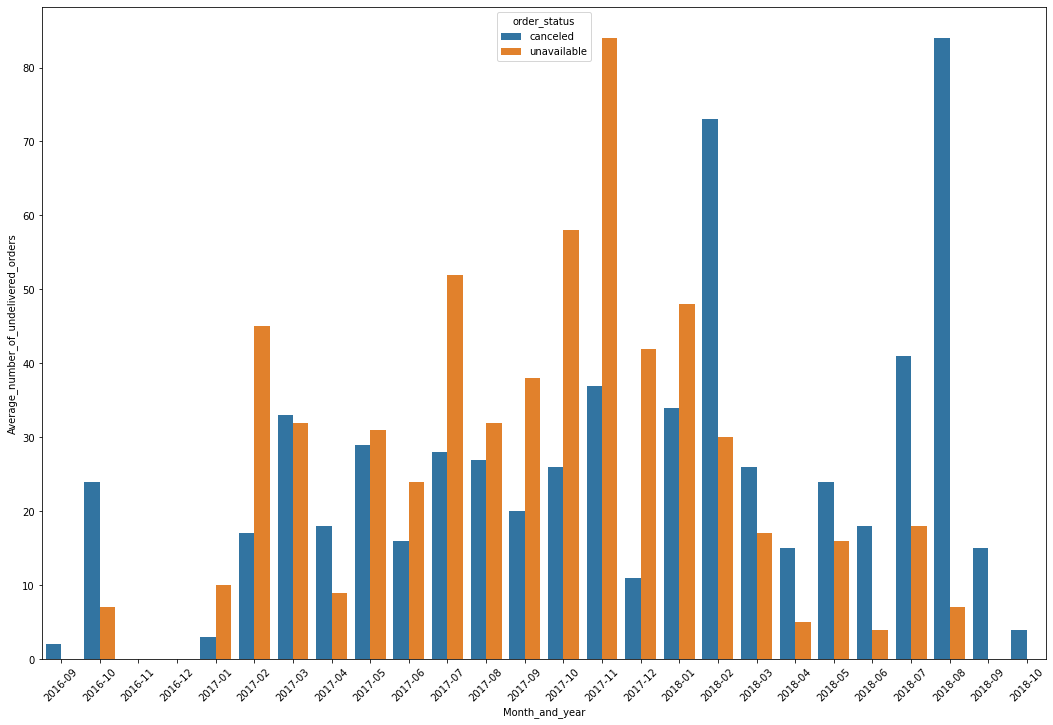

In [54]:
plt.figure(figsize=(18, 12))
sns.barplot(x="Month_and_year", hue="order_status", y="Average_number_of_undelivered_orders", data=unfulfilled_order)
plt.xticks(rotation=45)
plt.show()

### Ответ:

Общее количество недоставленных заказов (влючающих, хоть один недоставленный товар): 1234.

В среднем в месяц не доставляется порядка 48-ми заказов.

Основные причины: 
* canceled    =   24.038462
* unavailable  =  26.478261

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается. 

In [122]:
# Считаем, что датой  покупки является order_approved_at —  время подтверждения оплаты заказа

In [123]:
# Дасет с количеством совершённых покупок
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,shipping_limit_date,price,freight_value,day_of_week,order_year,order_month,weeks_in_month,b_day,month_of_purchase,month_diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-10-06 11:07:15,29.99,8.72,Monday,2017,10,4.43,2017-09,2017-10,1
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-09-11 11:43:25,35.39,8.72,Monday,2017,9,4.29,2017-09,2017-09,0
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-07-30 03:24:27,118.70,22.76,Thursday,2018,7,4.43,2018-07,2018-07,0
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018-08-13 08:55:23,159.90,19.22,Wednesday,2018,8,4.43,2018-08,2018-08,0
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017-11-23 19:45:59,45.00,27.20,Saturday,2017,11,4.29,2017-11,2017-11,0


In [124]:
purchases['day_of_week'] = purchases.order_approved_at.dt.day_name()

In [125]:
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,shipping_limit_date,price,freight_value,day_of_week,order_year,order_month,weeks_in_month,b_day,month_of_purchase,month_diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-10-06 11:07:15,29.99,8.72,Monday,2017,10,4.43,2017-09,2017-10,1
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017-09-11 11:43:25,35.39,8.72,Monday,2017,9,4.29,2017-09,2017-09,0
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018-07-30 03:24:27,118.70,22.76,Thursday,2018,7,4.43,2018-07,2018-07,0
3,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018-08-13 08:55:23,159.90,19.22,Wednesday,2018,8,4.43,2018-08,2018-08,0
4,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017-11-23 19:45:59,45.00,27.20,Saturday,2017,11,4.29,2017-11,2017-11,0


In [134]:
top_days = (
     purchases.groupby(['day_of_week', 'product_id'], as_index = [False, False]).agg({'price':'count'})
    .sort_values(['price','product_id'], ascending=[False, True])
    .reset_index() 
    .pivot(index='product_id', columns='day_of_week', values = 'price')
    .reset_index() 
    .fillna(0)
)
top_days

day_of_week,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009406fd7479715e4bef61dd91f2462,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
32721,fff6177642830a9a94a0f2cba5e476d1,0.0,1.0,1.0,0.0,0.0,0.0,0.0
32722,fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32723,fff9553ac224cec9d15d49f5a263411f,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32724,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,0.0,0.0,0.0,1.0,3.0,0.0


In [133]:
top_days = top_days.set_index('product_id') \
        .idxmax(axis=1) \
        .to_frame() \
        .reset_index() \
        .rename(columns={0:'best_day_of_purchase'}) \
        .head(10)
top_days
# И в финале получаем день недели, в который каждый товар чаще всего покупался

,product_id,best_day_of_purchase
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
5,0011c512eb256aa0dbbb544d8dffcf6e,Thursday
6,00126f27c813603687e6ce486d909d01,Sunday
7,001795ec6f1b187d37335e1c4704762e,Monday
8,001b237c0e9bb435f2e54071129237e9,Friday
9,001b72dfd63e9833e8c02742adf472e3,Thursday


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [65]:
# Добавляем следующие колонки:
purchases['order_year'] = purchases.order_purchase_timestamp.dt.year # колонка с годом 
purchases['order_month'] = purchases.order_purchase_timestamp.dt.month # с месяцем
purchases['weeks_in_month'] = round(purchases.order_purchase_timestamp.dt.days_in_month/7, 2) # с количеством недель

In [66]:
purchases.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week,order_year,order_month,weeks_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,2017,10,4.43
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday,2018,7,4.43
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday,2018,8,4.43


In [67]:
purchases_by_month = purchases.groupby(['customer_unique_id', 'order_year', 'order_month', 'weeks_in_month'], as_index=False) \
                              .agg({'order_id': 'nunique'}) \
                              .rename(columns={'order_id': 'number_of_purchases'})
purchases_by_month.head(5)

,customer_unique_id,order_year,order_month,weeks_in_month,number_of_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.43,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018,5,4.43,1
2,0000f46a3911fa3c0805444483337064,2017,3,4.43,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017,10,4.43,1
4,0004aac84e0df4da2b147fca70cf8255,2017,11,4.29,1


In [68]:
# Находим среднее количество покупок в неделю для каждого пользователя
purchases_by_month['avg_orders_week']= purchases_by_month['number_of_purchases']/purchases_by_month['weeks_in_month']
purchases_by_month.sort_values('avg_orders_week').head(5)

,customer_unique_id,order_year,order_month,weeks_in_month,number_of_purchases,avg_orders_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018,5,4.43,1,0.225734
56534,958a09f1a17bfaa6ca721b5aa01f59f6,2018,5,4.43,1,0.225734
56535,958ac7760e5484df1496ba5833ab6117,2018,8,4.43,1,0.225734
56538,958cf844b291da7070d18be8bd93aef3,2018,3,4.43,1,0.225734
56539,958d8d0c2c3441ddbe3d776374f45261,2018,5,4.43,1,0.225734


In [69]:
# Среднее число покупок в неделю по всем пользователям.
round(purchases_by_month.avg_orders_week.mean(), 2)


0.23

### Ответ:  0.23 

Это означает, что наш среднестатистический пользователь  покупает не каждую неделю.

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [70]:
# Определим дату, когда была совершена первая покупка каждым пользователем (b_day - день рождения)

first_purchase = purchases.groupby('customer_unique_id') \
                      .agg({'order_purchase_timestamp': 'min'}) \
                      .rename(columns={'order_purchase_timestamp': 'b_day'}) \
                      .b_day.dt.to_period('M')
first_purchase

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    2018-05
0000b849f77a49e4a4ce2b2a4ca5be3f    2018-05
0000f46a3911fa3c0805444483337064    2017-03
0000f6ccb0745a6a4b88665a16c9f078    2017-10
0004aac84e0df4da2b147fca70cf8255    2017-11
                                     ...   
fffcf5a5ff07b0908bd4e2dbc735a684    2017-06
fffea47cd6d3cc0a88bd621562a9d061    2017-12
ffff371b4d645b6ecea244b27531430a    2017-02
ffff5962728ec6157033ef9805bacc48    2018-05
ffffd2657e2aad2907e67c3e9daecbeb    2017-05
Name: b_day, Length: 94973, dtype: period[M]

In [71]:
# вставим серию в датафрейм purchases
purchases = pd.merge(purchases, first_purchase, on='customer_unique_id')
purchases.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week,order_year,order_month,weeks_in_month,b_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,2017,10,4.43,2017-09
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,...,9abb00920aae319ef9eba674b7d2e6ff,1771297ac436903d1dd6b0e9279aa505,2017-09-11 11:43:25,35.39,8.72,Monday,2017,9,4.29,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday,2018,7,4.43,2018-07


In [72]:
# создадим колонку такого же формата с датами всех заказов
purchases['month_of_purchase'] = purchases.order_purchase_timestamp.dt.to_period('M')

In [73]:
purchases.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,seller_id,shipping_limit_date,price,freight_value,day_of_week,order_year,order_month,weeks_in_month,b_day,month_of_purchase
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,2017,10,4.43,2017-09,2017-10
1,69923a4e07ce446644394df37a710286,31f31efcb333fcbad2b1371c8cf0fa84,delivered,2017-09-04 11:26:38,2017-09-04 11:43:25,2017-09-04 21:22:15,2017-09-05 19:20:20,2017-09-15,7c396fd4830fd04220f754e42b4e5bff,3149,...,1771297ac436903d1dd6b0e9279aa505,2017-09-11 11:43:25,35.39,8.72,Monday,2017,9,4.29,2017-09,2017-09
2,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday,2018,7,4.43,2018-07,2018-07


In [74]:
# для каждой покупки узнаем сколько времени прошло с первого заказа
purchases['month_diff'] = purchases['month_of_purchase'].subtract(purchases['b_day']) \
                                                       .apply(lambda x: x.n)

In [75]:
# развернем полученные данные 
cohort_table = purchases.pivot_table(
                                      columns='month_diff',
                                      index='b_day',
                                      values='customer_unique_id',
                                      aggfunc='nunique')
cohort_table

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,290.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,750.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1678.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [76]:
# найдем retention rate
retention_table = cohort_table.div(cohort_table[0], axis=0)
retention_table 

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003448,NaN,NaN,0.003448,NaN,0.003448,NaN,0.003448,NaN,0.003448,NaN,0.003448,0.006897,0.006897
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.004000,0.002667,0.001333,0.004000,0.001333,0.004000,0.001333,0.001333,NaN,0.004000,0.001333,0.006667,0.004000,0.001333,0.001333,0.002667,0.004000,0.001333,NaN
2017-02,1.0,0.002384,0.002980,0.001192,0.004172,0.001192,0.002384,0.001788,0.000596,0.001788,0.001192,0.002980,0.001192,0.001788,0.001192,0.000596,0.000596,0.002384,NaN,NaN
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,0.001167,0.001556,0.002334,0.000778,0.001556,NaN,NaN
2017-04,1.0,0.006022,0.002151,0.001720,0.003011,0.002581,0.003441,0.003011,0.003011,0.001720,0.002581,0.000860,0.000860,0.000430,0.000860,0.000860,0.001290,NaN,NaN,NaN
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,0.003389,0.002542,0.000282,0.001977,0.002259,NaN,NaN,NaN,NaN
2017-06,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,0.002257,0.001289,0.002257,0.003224,0.003224,0.001612,0.001289,0.001934,NaN,NaN,NaN,NaN,NaN


In [77]:
retention_2017 = retention_table.loc['2017-01': '2017-12']
retention_2017 

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2017-01,1.0,0.004000,0.002667,0.001333,0.004000,0.001333,0.004000,0.001333,0.001333,NaN,0.004000,0.001333,0.006667,0.004000,0.001333,0.001333,0.002667,0.004000,0.001333,NaN
2017-02,1.0,0.002384,0.002980,0.001192,0.004172,0.001192,0.002384,0.001788,0.000596,0.001788,0.001192,0.002980,0.001192,0.001788,0.001192,0.000596,0.000596,0.002384,NaN,NaN
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,0.001167,0.001556,0.002334,0.000778,0.001556,NaN,NaN
2017-04,1.0,0.006022,0.002151,0.001720,0.003011,0.002581,0.003441,0.003011,0.003011,0.001720,0.002581,0.000860,0.000860,0.000430,0.000860,0.000860,0.001290,NaN,NaN,NaN
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,0.003389,0.002542,0.000282,0.001977,0.002259,NaN,NaN,NaN,NaN
2017-06,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,0.002257,0.001289,0.002257,0.003224,0.003224,0.001612,0.001289,0.001934,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005233,0.003401,0.002355,0.002878,0.002093,0.003140,0.001047,0.001832,0.002616,0.002093,0.002878,0.001308,0.002616,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006780,0.003390,0.002663,0.003632,0.005327,0.002906,0.002663,0.001453,0.001453,0.002421,0.001937,0.001211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006871,0.005399,0.002945,0.004417,0.002209,0.002209,0.002454,0.002945,0.001718,0.002699,0.000736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
ur_style = (retention_2017
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='Greens',low=0.2, high=1, axis =0)
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
ur_style

month_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
b_day,,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.67%,0.40%,0.13%,0.13%,0.27%,0.40%,0.13%,
2017-02,100.00%,0.24%,0.30%,0.12%,0.42%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.25%,0.34%,0.25%,0.03%,0.20%,0.23%,,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.39%,0.35%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,,
2017-07,100.00%,0.52%,0.34%,0.24%,0.29%,0.21%,0.31%,0.10%,0.18%,0.26%,0.21%,0.29%,0.13%,0.26%,,,,,,
2017-08,100.00%,0.68%,0.34%,0.27%,0.36%,0.53%,0.29%,0.27%,0.15%,0.15%,0.24%,0.19%,0.12%,,,,,,,
2017-09,100.00%,0.69%,0.54%,0.29%,0.44%,0.22%,0.22%,0.25%,0.29%,0.17%,0.27%,0.07%,,,,,,,,


In [83]:
print(retention_2017.loc[:][3].idxmax())
print(retention_2017.loc[:][3].max())

2017-05
0.003953685399604632


### Ответ: Когорта с самым высоким retention на 3й месяц: "2017-05"

# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации.

# Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

Выделим основные этапы для получения RFM оценки клиентов и рассчёта оценок R, F и M по шкале от 1 (худший) до 5 (лучший).

Основные этапы:
1. рассчитать недавность = количество дней с момента последней покупки
2. рассчитать частоту = количество покупок за исследуемый период (обычно один год)
3. рассчитать стоимость/сумму трат клиента в денежном выражении = общая сумма покупок, сделанных за исследуемый период
4. найти квинтили для каждого из этих измерений
5. расценить каждый параметр в зависимости от того, в каком квинтиле он находится
6. объединить баллы R, F и M, чтобы получить балл RFM
7. сопоставить оценки RF с сегментами


In [84]:
df.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [85]:
# избавим наш dataset от NaN значений
df.dropna(inplace=True)

In [86]:
# Определяем момент времени для определения понятия "актуальность". 
# смоделируем наш сегодняшний день(под данным предполагаю плюс 1 день к максимальному дню доставки):
NOW = df['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-08-30 15:00:37')

In [87]:
# Далее группируем RFM таблицу, на основе которой мы и бдуем собирать RFM показатель 
# и  меняем названия столбцов для более удобства:

RFM_table = df.reset_index().groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (NOW - x.max()).days,
                                                                   'order_id': lambda x: len(x),
                                                                   'price': lambda x: x.sum()})

In [88]:
RFM_table.head(3)

,order_purchase_timestamp,order_id,price
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
0000f46a3911fa3c0805444483337064,537,1,69.0


In [89]:
RFM_table.rename(columns={'order_purchase_timestamp': 'recency',
                         'order_id': 'frequency',
                         'price': 'monetary'}, inplace=True)

In [90]:
RFM_table.head(3)

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.9
0000f46a3911fa3c0805444483337064,537,1,69.0


In [91]:
RFM_table.frequency.value_counts()
# Видим, что у нас очень много юзеров, которые покупали лишь 1 раз, поэтому для каждого параметра в RFM напишем по функции :)

1     81733
2      8796
3      1646
4       621
5       241
6       190
7        45
8        16
10       11
11       11
9        10
12        9
15        3
14        3
20        2
13        2
18        1
21        1
24        1
Name: frequency, dtype: int64

In [92]:
# Создадим функцию, которая  будет делить наших пользователей по разным показателям RFM:

In [93]:
quantiles = RFM_table.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = RFM_table

In [94]:
def RScore(x,p,d):
    if x <= d[p][0.20]:
        return 5
    elif x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.60]:
        return 3
    elif x<=d[p][0.80]:
        return 2
    else:
        return 1

In [95]:
def FMScore(x,p,d):
    if x <= d[p][0.20]:
        return 1
    elif x <= d[p][0.40]:
        return 2
    elif x <= d[p][0.60]:
        return 3
    elif x<=d[p][0.80]:
        return 4
    else:
        return 5

In [96]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=("frequency",quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


In [97]:
segmented_rfm.RFMScore.nunique()

50

In [98]:
segmented_rfm.RFMScore.unique()

array(['414', '411', '112', '211', '215', '355', '114', '413', '111',
       '213', '412', '113', '311', '255', '512', '511', '555', '115',
       '254', '214', '313', '552', '513', '252', '554', '514', '315',
       '253', '212', '515', '455', '314', '415', '452', '153', '312',
       '454', '351', '155', '553', '353', '154', '152', '453', '451',
       '354', '251', '551', '151', '352'], dtype=object)

In [99]:
# Получили таблички с RFM_score
# Чем больший показатель получаем, тем лучше,
# например показатель 555 - тут платят недавно(R), часто(F), и много (M).
    # То есть такой пользователь самый лояльный и самый активный
# А если показатель 111 - платил очень давно(R), очень редко(F), и слишком мало(M)
    # Считай, что клиент потерян безвозвратно, и смысла его возвращать уже не будет.

In [100]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',         # Покупал очень давно, и заказов было мало. Считай, утерян!
    r'[1-2][3-4]': 'at risk',             # Покупал часто, но давно. Надо бы вернуть!
    r'[1-2]5': 'can\'t loose',            # Возвращался давно, хотя покупал часто. Надо бы вернуть!
    r'3[1-2]': 'about to sleep',          # Ниже среднего, нужно стимулировать, чтобы вернуть!
    r'33': 'need attention',              # Довольно средний пользователь, вроде не убегает.
    r'[3-4][4-5]': 'loyal customers',     # Покупает регулярно, на акции реагирует
    r'41': 'promising',                   # Покупал недавно, но много не тратит
    r'51': 'new customers',               # Был недавно, но покупает пока что не часто
    r'[4-5][2-3]': 'potential loyalists', # Клиент недавний, покупает довольно средне
    r'5[4-5]': 'champions'                # Тратит много, часто, регулярно!
}

segmented_rfm['Segment'] = segmented_rfm['r_quartile'].map(str) + segmented_rfm['f_quartile'].map(str)
segmented_rfm['Segment'] = segmented_rfm['Segment'].replace(segt_map, regex=True)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,hibernating
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,hibernating


In [101]:
RFM_segments_size = segmented_rfm.groupby('Segment', as_index = False)\
                                 .agg({'RFMScore': 'count'}).sort_values('RFMScore', ascending=False)
RFM_segments_size['share'] = round(RFM_segments_size.RFMScore / sum(RFM_segments_size.RFMScore),2)

RFM_segments_size

,Segment,RFMScore,share
3,hibernating,32623,0.35
5,new customers,16427,0.18
0,about to sleep,16407,0.18
6,promising,16276,0.17
4,loyal customers,4732,0.05
1,can't loose,4582,0.05
2,champions,2295,0.02


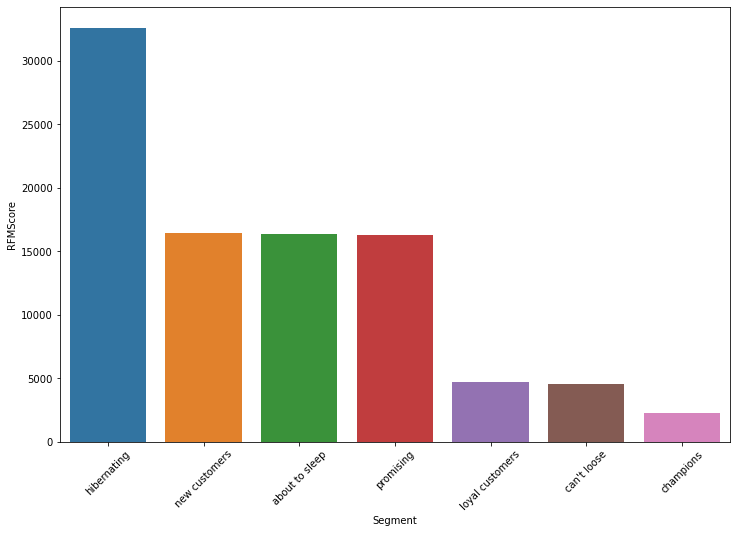

In [102]:
plt.figure(figsize=(12, 8))
barplot_RFM = sns.barplot(x='Segment', y='RFMScore', data=RFM_segments_size)
plt.xticks(rotation=45)
plt.show()

Как мы видим из данной диаграммы, подавляющее количество (35%) клиентов относятся к сигменту 'глубокоспящие' (hibernating), которые покупали редко и давно, могут уже и не вернутся. 
Основная аудитория (53%) - это new customers, 'about to sleep', 'promising' совершает покупки не часто, можно было бы провести рекламную компанию, чтобы их активировать.
Лояльные покупатели ('champions' , 'loyal customers') составляют 7%. Лояльность можно поддержать спец. условиями)
Особое внимание нужно уделить сигменту 'can't loose', пользователям, которые часто совершали покупки, а затем перестали.